<a href="https://colab.research.google.com/github/sergekamanzi/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Logistic Regression (Traditional Machine Learning Model)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Columns: Index(['review', 'sentiment'], dtype='object')

Missing Values:
      Column  Missing Values
0     review               0
1  sentiment               0


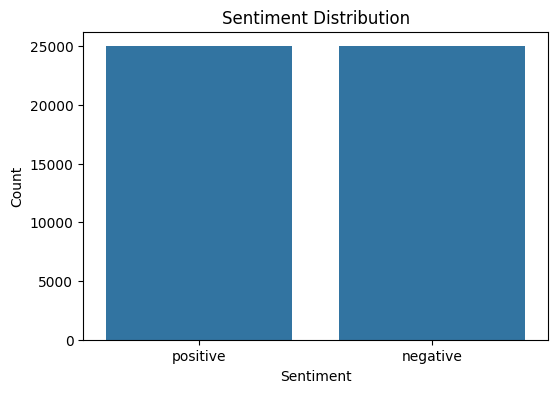


Sentiment Value Counts:
sentiment
1    25000
0    25000
Name: count, dtype: int64


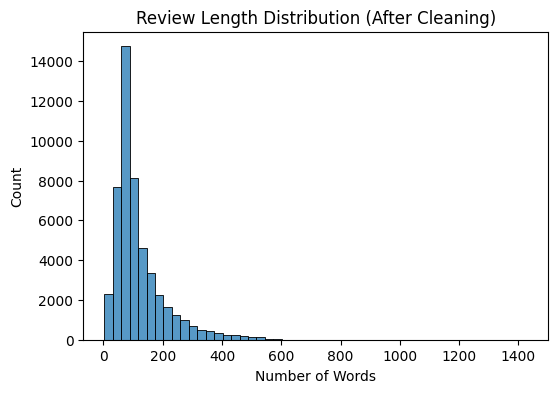


Logistic Regression Experiment Results:
      C     Solver  Accuracy  Precision    Recall  F1-Score
0  0.01  liblinear    0.8347   0.816685  0.866442  0.840828
1  0.01      lbfgs    0.8342   0.815686  0.866839  0.840485
2  0.10  liblinear    0.8713   0.856383  0.894622  0.875085
3  0.10      lbfgs    0.8711   0.856058  0.894622  0.874915
4  1.00  liblinear    0.8865   0.877855  0.899980  0.888780
5  1.00      lbfgs    0.8865   0.878002  0.899782  0.888758

Final Logistic Regression Metrics:
Accuracy: 0.8865
Precision: 0.8779
Recall: 0.9000
F1-Score: 0.8888


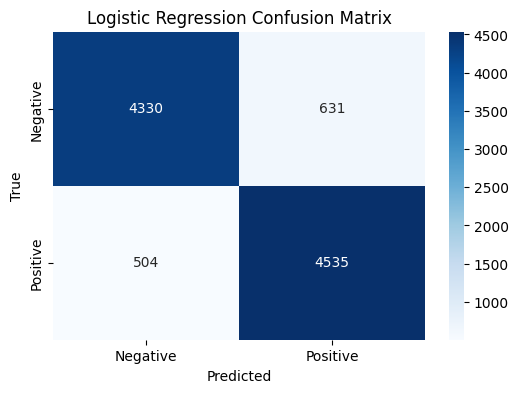

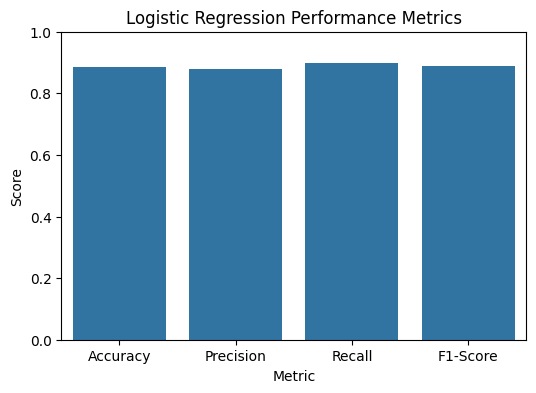

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
from sklearn.metrics import confusion_matrix  # Added for confusion matrix visualization

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Added to fix the LookupError
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset from local file (uploaded to Colab)
# Replace 'your_dataset.csv' with the name of your CSV file
# Ensure the file is uploaded to /content/ in Colab
data = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8')

# Verify dataset columns
# If your dataset does not have 'review' and 'sentiment' columns, update these names to match your dataset
print("Dataset Columns:", data.columns)
# Example: If your columns are 'text' and 'label', replace 'review' with 'text' and 'sentiment' with 'label' below

# Check for missing values
missing_values = data.isnull().sum()
missing_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})
print("\nMissing Values:")
print(missing_df)

# Handle missing values (if any)
# Replace missing reviews with empty strings and drop rows with missing sentiment
data['review'] = data['review'].fillna('')  # Update 'review' to your text column name
data = data.dropna(subset=['sentiment'])  # Update 'sentiment' to your label column name

# --- Visualization: Sentiment Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# --- Preprocessing ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(tokens)

# Apply text cleaning
# Update 'review' to your text column name if different
data['cleaned_review'] = data['review'].apply(clean_text)

# Convert sentiment labels to binary (positive=1, negative=0)
# Update 'sentiment' to your label column name if different
# Adjust mapping based on your dataset's sentiment labels (e.g., 'positive'/'negative' or others)
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Verify sentiment conversion
print("\nSentiment Value Counts:")
print(data['sentiment'].value_counts())

# --- Visualization: Review Length Distribution ---
data['review_length'] = data['cleaned_review'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(6,4))
sns.histplot(data['review_length'], bins=50)
plt.title('Review Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# Split data
# Update 'cleaned_review' and 'sentiment' to match your column names if different
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

# --- TF-IDF for Logistic Regression ---
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# --- Logistic Regression Experiments ---
lr_results = []
C_values = [0.01, 0.1, 1.0]
solvers = ['liblinear', 'lbfgs']

for C in C_values:
    for solver in solvers:
        model_lr = LogisticRegression(C=C, solver=solver, max_iter=1000)
        model_lr.fit(X_train_tfidf, y_train)
        y_pred = model_lr.predict(X_test_tfidf)
        lr_results.append({
            'C': C,
            'Solver': solver,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })

# Display Logistic Regression results
lr_results_df = pd.DataFrame(lr_results)
print("\nLogistic Regression Experiment Results:")
print(lr_results_df)
lr_results_df.to_csv('/content/lr_results.csv', index=False)

# Train final Logistic Regression model (best parameters: C=1.0, solver='liblinear')
model_lr = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)
print("\nFinal Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")

# --- Visualization: Confusion Matrix ---
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- Visualization: Performance Metrics Bar Plot ---
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr)
    ]
})
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('Logistic Regression Performance Metrics')
plt.ylim(0, 1)
plt.show()

LSTM with Word2Vec Embeddings (Deep Learning Model)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
data = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8')

# Verify dataset columns
print("Dataset Columns:", data.columns)

# Check for missing values
missing_values = data.isnull().sum()
missing_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})
print("\nMissing Values:")
print(missing_df)

# Handle missing values
data['review'] = data['review'].fillna('')
data = data.dropna(subset=['sentiment'])

# --- Visualization: Sentiment Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.close()

# --- Preprocessing ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(tokens)  # Return cleaned text as string for TF-IDF

# Apply text cleaning
data['cleaned_review'] = data['review'].apply(clean_text)

# Convert sentiment labels to binary
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Verify sentiment conversion
print("\nSentiment Value Counts:")
print(data['sentiment'].value_counts())

# --- Visualization: Review Length Distribution ---
data['review_length'] = data['cleaned_review'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(6,4))
sns.histplot(data['review_length'], bins=50)
plt.title('Review Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.close()

# --- TF-IDF Vectorization ---
max_features = 5000
max_len = 200  # Maximum sequence length for LSTM
tfidf = TfidfVectorizer(max_features=max_features)
X_tfidf = tfidf.fit_transform(data['cleaned_review']).toarray()

# Truncate or pad TF-IDF features to fixed length for LSTM
def truncate_or_pad_features(features, max_len):
    if features.shape[1] > max_len:
        return features[:, :max_len]
    elif features.shape[1] < max_len:
        return np.pad(features, ((0, 0), (0, max_len - features.shape[1])), mode='constant')
    return features

X_tfidf = truncate_or_pad_features(X_tfidf, max_len)
y = data['sentiment'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# --- LSTM Model ---
model_lstm = Sequential([
    LSTM(128, input_shape=(max_len, 1), return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype(int)
print("\nLSTM with TF-IDF Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lstm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lstm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lstm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lstm):.4f}")

# --- Visualization: Confusion Matrix ---
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.close()

# --- Visualization: Performance Metrics Bar Plot ---
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy_score(y_test, y_pred_lstm),
        precision_score(y_test, y_pred_lstm),
        recall_score(y_test, y_pred_lstm),
        f1_score(y_test, y_pred_lstm)
    ]
})
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('LSTM Performance Metrics')
plt.ylim(0, 1)
plt.close()

# --- Visualization: Training History ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Dataset Columns: Index(['review', 'sentiment'], dtype='object')

Missing Values:
      Column  Missing Values
0     review               0
1  sentiment               0

Sentiment Value Counts:
sentiment
1    25000
0    25000
Name: count, dtype: int64
Epoch 1/5
500/500 [==============================] - 179s 354ms/step - loss: 0.6935 - accuracy: 0.5036 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
500/500 [==============================] - 171s 342ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
500/500 [==============================] - 176s 352ms/step - loss: 0.6933 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
500/500 [==============================] - 176s 352ms/step - loss: 0.6933 - accuracy: 0.4970 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/5
313/313 [==============================] - 30s 93ms/step

LSTM with TF-IDF Metrics:
Accuracy: 0.5038
Precision: 0.5039
Recall: 0.9988
F1-Score: 0.6698
